In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# global imports
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# local imports
sys.path.append('../src/') # local path
import dautils

### Read dataframe

In [2]:
# read dataset
df = pd.read_csv('../data/adult_continuous.csv', na_values='?')
# remove unused columns
del df['fnlwgt']
del df['education-num']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       46043 non-null  object
 2   education       48842 non-null  object
 3   marital-status  48842 non-null  object
 4   occupation      46033 non-null  object
 5   relationship    48842 non-null  object
 6   race            48842 non-null  object
 7   sex             48842 non-null  object
 8   capital-gain    48842 non-null  int64 
 9   capital-loss    48842 non-null  int64 
 10  hours-per-week  48842 non-null  int64 
 11  native-country  47985 non-null  object
 12  class           48842 non-null  object
dtypes: int64(4), object(9)
memory usage: 4.8+ MB


In [3]:
# some missing values present
df.isna().sum()

age                  0
workclass         2799
education            0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
class                0
dtype: int64

In [4]:
df.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
# nominal-ordinal-continuous partition of predictive attributes
nominal_atts = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
ordinal_atts = ['education']
continuous_atts = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']
# class attribute
target = 'class'
# predictive and all atts
pred_atts = nominal_atts + ordinal_atts + continuous_atts
all_atts = pred_atts + [target]

### Encoding 

In [6]:
# forcing encoding of ordinal attributes (consistent with the order) and class attribute (0=negatives, 1=positives)
decode = {
    'education': {
        1:'Preschool', 2:'1st-4th', 3:'5th-6th', 4:'7th-8th', 5:'9th', 6:'10th', 7:'11th',
        8:'12th', 9:'HS-grad', 10:'Some-college', 11:'Assoc-voc', 12:'Assoc-acdm', 13:'Bachelors', 
        14:'Masters', 15:'Prof-school', 16:'Doctorate' 
    },
    'class': {
        0: '<=50K', 1: '>50K'
    }
}

In [7]:
# encode nominal (as categories), ordinal+target (as int), passing the encoding of ordinal+target
df_code = dautils.Encode(nominal=nominal_atts, ordinal=ordinal_atts+[target], decode=decode)
df_encoded = df_code.fit_transform(df)
# workclass, occupation and native-country are floats because there are missing values
df_encoded.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,6.0,13,4,0.0,1,4,1,2174,0,40,38.0,0
1,50,5.0,13,2,3.0,0,4,1,0,0,13,38.0,0
2,38,3.0,9,0,5.0,1,4,1,0,0,40,38.0,0
3,53,3.0,7,2,5.0,0,2,1,0,0,40,38.0,0
4,28,3.0,13,2,9.0,5,2,0,0,0,40,4.0,0


In [8]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48842 non-null  int64   
 1   workclass       46043 non-null  category
 2   education       48842 non-null  int32   
 3   marital-status  48842 non-null  category
 4   occupation      46033 non-null  category
 5   relationship    48842 non-null  category
 6   race            48842 non-null  category
 7   sex             48842 non-null  category
 8   capital-gain    48842 non-null  int64   
 9   capital-loss    48842 non-null  int64   
 10  hours-per-week  48842 non-null  int64   
 11  native-country  47985 non-null  category
 12  class           48842 non-null  int32   
dtypes: category(7), int32(2), int64(4)
memory usage: 2.2 MB


In [9]:
# dictionary of encodings for discrete (nominal+ordinal+target) columns
df_code.decode

{'education': {1: 'Preschool',
  2: '1st-4th',
  3: '5th-6th',
  4: '7th-8th',
  5: '9th',
  6: '10th',
  7: '11th',
  8: '12th',
  9: 'HS-grad',
  10: 'Some-college',
  11: 'Assoc-voc',
  12: 'Assoc-acdm',
  13: 'Bachelors',
  14: 'Masters',
  15: 'Prof-school',
  16: 'Doctorate'},
 'class': {0: '<=50K', 1: '>50K'},
 'sex': {0: 'Female', 1: 'Male'},
 'native-country': {0: 'Cambodia',
  1: 'Canada',
  2: 'China',
  3: 'Columbia',
  4: 'Cuba',
  5: 'Dominican-Republic',
  6: 'Ecuador',
  7: 'El-Salvador',
  8: 'England',
  9: 'France',
  10: 'Germany',
  11: 'Greece',
  12: 'Guatemala',
  13: 'Haiti',
  14: 'Holand-Netherlands',
  15: 'Honduras',
  16: 'Hong',
  17: 'Hungary',
  18: 'India',
  19: 'Iran',
  20: 'Ireland',
  21: 'Italy',
  22: 'Jamaica',
  23: 'Japan',
  24: 'Laos',
  25: 'Mexico',
  26: 'Nicaragua',
  27: 'Outlying-US(Guam-USVI-etc)',
  28: 'Peru',
  29: 'Philippines',
  30: 'Poland',
  31: 'Portugal',
  32: 'Puerto-Rico',
  33: 'Scotland',
  34: 'South',
  35: 'Taiwan'

In [10]:
# from encoded back to orignal
df_back = df_code.inverse_transform(df_encoded)
df_back.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Encoding with onehot option

In [11]:
df_code = dautils.Encode(nominal=nominal_atts, ordinal=ordinal_atts+[target], decode=decode, onehot=True)
df_encoded_onehot = df_code.fit_transform(df)
df_encoded_onehot.head()

,age,workclass=Federal-gov,workclass=Local-gov,workclass=Never-worked,workclass=Private,workclass=Self-emp-inc,workclass=Self-emp-not-inc,workclass=State-gov,workclass=Without-pay,education,...,native-country=Puerto-Rico,native-country=Scotland,native-country=South,native-country=Taiwan,native-country=Thailand,native-country=Trinadad&Tobago,native-country=United-States,native-country=Vietnam,native-country=Yugoslavia,class
0,39,0,0,0,0,0,0,1,0,13,...,0,0,0,0,0,0,1,0,0,0
1,50,0,0,0,0,0,1,0,0,13,...,0,0,0,0,0,0,1,0,0,0
2,38,0,0,0,1,0,0,0,0,9,...,0,0,0,0,0,0,1,0,0,0
3,53,0,0,0,1,0,0,0,0,7,...,0,0,0,0,0,0,1,0,0,0
4,28,0,0,0,1,0,0,0,0,13,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# dictionary of encodings now does not include nominal
df_code.decode

{'education': {1: 'Preschool',
  2: '1st-4th',
  3: '5th-6th',
  4: '7th-8th',
  5: '9th',
  6: '10th',
  7: '11th',
  8: '12th',
  9: 'HS-grad',
  10: 'Some-college',
  11: 'Assoc-voc',
  12: 'Assoc-acdm',
  13: 'Bachelors',
  14: 'Masters',
  15: 'Prof-school',
  16: 'Doctorate'},
 'class': {0: '<=50K', 1: '>50K'},
 'sex': {0: 'Female', 1: 'Male'},
 'native-country': {0: 'Cambodia',
  1: 'Canada',
  2: 'China',
  3: 'Columbia',
  4: 'Cuba',
  5: 'Dominican-Republic',
  6: 'Ecuador',
  7: 'El-Salvador',
  8: 'England',
  9: 'France',
  10: 'Germany',
  11: 'Greece',
  12: 'Guatemala',
  13: 'Haiti',
  14: 'Holand-Netherlands',
  15: 'Honduras',
  16: 'Hong',
  17: 'Hungary',
  18: 'India',
  19: 'Iran',
  20: 'Ireland',
  21: 'Italy',
  22: 'Jamaica',
  23: 'Japan',
  24: 'Laos',
  25: 'Mexico',
  26: 'Nicaragua',
  27: 'Outlying-US(Guam-USVI-etc)',
  28: 'Peru',
  29: 'Philippines',
  30: 'Poland',
  31: 'Portugal',
  32: 'Puerto-Rico',
  33: 'Scotland',
  34: 'South',
  35: 'Taiwan'

In [13]:
# from encoded back to original
df_onehot_back = df_code.inverse_transform(df_encoded_onehot)
df_onehot_back.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [14]:
# encoded atts names
encoded_pred_atts = df_code.encoded_atts(pred_atts)
encoded_pred_atts

['workclass=Federal-gov',
 'workclass=Local-gov',
 'workclass=Never-worked',
 'workclass=Private',
 'workclass=Self-emp-inc',
 'workclass=Self-emp-not-inc',
 'workclass=State-gov',
 'workclass=Without-pay',
 'marital-status=Divorced',
 'marital-status=Married-AF-spouse',
 'marital-status=Married-civ-spouse',
 'marital-status=Married-spouse-absent',
 'marital-status=Never-married',
 'marital-status=Separated',
 'marital-status=Widowed',
 'occupation=Adm-clerical',
 'occupation=Armed-Forces',
 'occupation=Craft-repair',
 'occupation=Exec-managerial',
 'occupation=Farming-fishing',
 'occupation=Handlers-cleaners',
 'occupation=Machine-op-inspct',
 'occupation=Other-service',
 'occupation=Priv-house-serv',
 'occupation=Prof-specialty',
 'occupation=Protective-serv',
 'occupation=Sales',
 'occupation=Tech-support',
 'occupation=Transport-moving',
 'relationship=Husband',
 'relationship=Not-in-family',
 'relationship=Other-relative',
 'relationship=Own-child',
 'relationship=Unmarried',
 're

In [15]:
# train a decision tree
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(df_encoded_onehot[encoded_pred_atts], df_encoded_onehot[target])

DecisionTreeClassifier(max_depth=3)

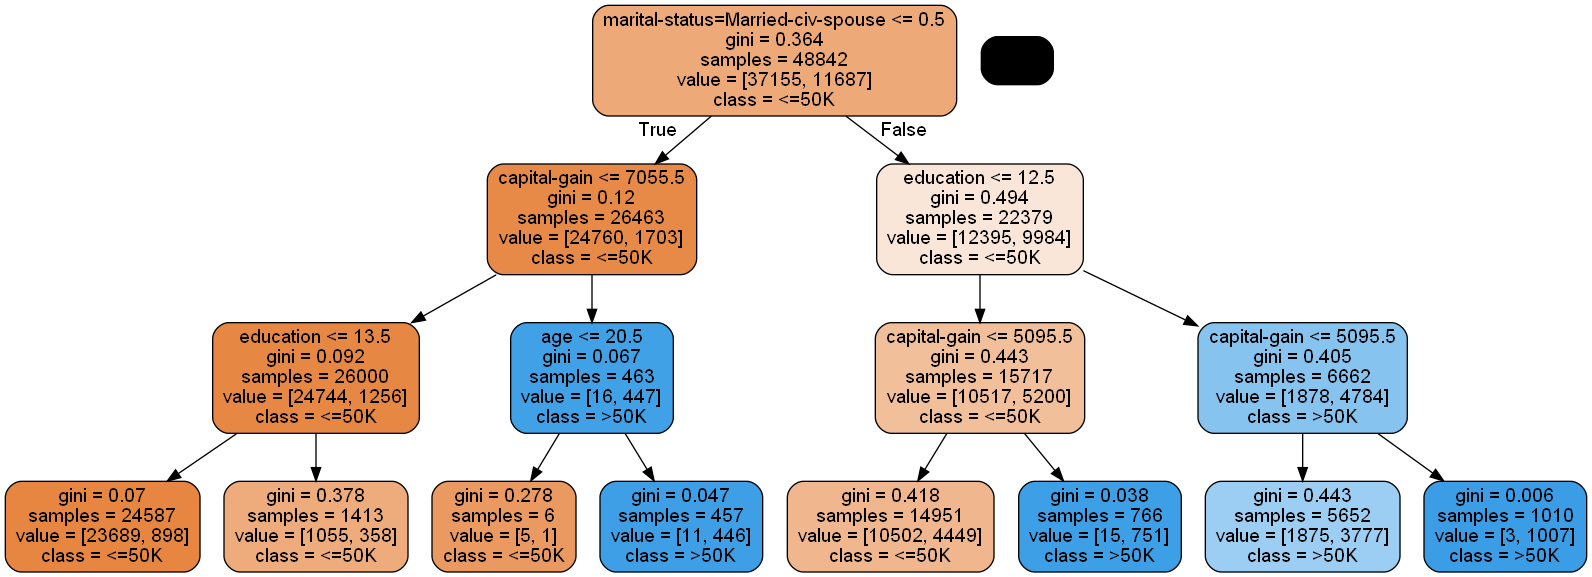

In [16]:
# visualize the decision tree
from sklearn import tree
from IPython.display import Image
import pydotplus

dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=encoded_pred_atts, # attributes names
                                class_names=df_code.decode[target], # class labels
                                filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())